##**Load Data and Libraries**


In [2]:
# data wrangling
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
# surpress warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing titanic dataset
df = pd.read_csv('/content/titanic.csv')

##**Find missing values in a DataFrame**


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Overview**

PassengerId is the unique id of the row and it doesn't have any effect on target

Survived is the target variable we are trying to predict (0 or 1):

* 1 = Survived
* 0 = Not Survived

Pclass (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
* 1 = Upper Class
* 2 = Middle Class
* 3 = Lower Class

Name, Sex and Age are self-explanatory

SibSp is the total number of the passengers' siblings and spouse

Parch is the total number of the passengers' parents and children

Ticket is the ticket number of the passenger

Fare is the passenger fare

Cabin is the cabin number of the passenger

Embarked is port of embarkation and it is a categorical feature which has 3 - unique values (C, Q or S):
* C = Cherbourg
* Q = Queenstown
* S = Southampton

In [5]:
#Looking data format and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Data Type

The training data consists of 12 columns, including 11 features and 1 target variable, with different data types:

- **Object/String**: Name, Sex, Ticket, Cabin, Embarked

- **Float/Real**: Age and Fare

- **Integer**: PassengerId, Survived (target), Pclass, SibSp, Parch

# ***Missing Values***

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As can be seen, there are some columns that have missing values.

* There are 177 missing values in Age

* There are 687 missing values in Cabin

* There are 2 missing values in Embarked

**Age**

Missing values in Age are filled with median age, but using median age of the whole data set is not a good choice. Median age of Pclass groups is the best choice because of its high correlation with Age ***(0.369116)***. It is also more logical to group ages by passenger classes instead of other features.


In [7]:
df_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
5,Age,Age,1.000000
12,Age,Pclass,0.369226
16,Age,SibSp,0.308247
21,Age,Parch,0.189119
26,Age,Fare,0.096067
32,Age,Survived,0.077221
36,Age,PassengerId,0.036847


In order to be more accurate, Sex feature is used as the second level of groupby while filling the missing Age values.
The median ages below are used for filling the missing values in Age feature.


In [8]:
age_by_pclass_sex = df.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 35.0
Median age of Pclass 1 males: 40.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 30.0
Median age of Pclass 3 females: 21.5
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


As seen, Pclass and Sex groups have distinct median Age values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median Age than males.

**Cabin**

With this many missing values, it's probably best for us to just drop this column completely.

In [9]:
# Dropping the Cabin feature
df.drop(['Cabin'], inplace=True, axis=1)

**Embarked**

Embarked is a categorical feature and there are only 2 missing values in whole data set. so we can handle them by imputing a specified value.
S is the most common embarkation port for the passengers. We will replace the null value in the Embarked column with S.

In [10]:
# Filling the missing values in Embarked with S
df['Embarked'] = df['Embarked'].fillna('S')

In [11]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Great! We've dealt with all the obvious missing values


# ***Exploratory Data Analysis***





**Target Distribution**


342 of 891 passengers survived and it is the 38.38%.
549 of 891 passengers didnt survive and it is the 61.62%.


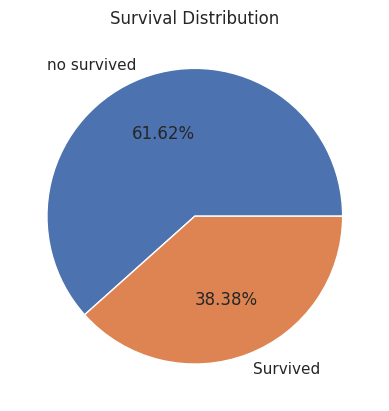

In [12]:
survived = df['Survived'].value_counts()[1]
not_survived = df['Survived'].value_counts()[0]
survived_per = survived / df.shape[0] * 100
not_survived_per = not_survived / df.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}%.'.format(survived, df.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}%.'.format(not_survived, df.shape[0], not_survived_per))

plt.pie(df['Survived'].value_counts(),autopct='%.2f%%',labels=["no survived", "Survived"])
plt.title('Survival Distribution')

plt.show()


So, We can observe that only 38.38% or 342 of the passanger survived (1), 61.62% or 549 of the passanger not survived (0)

 ****categorical data****

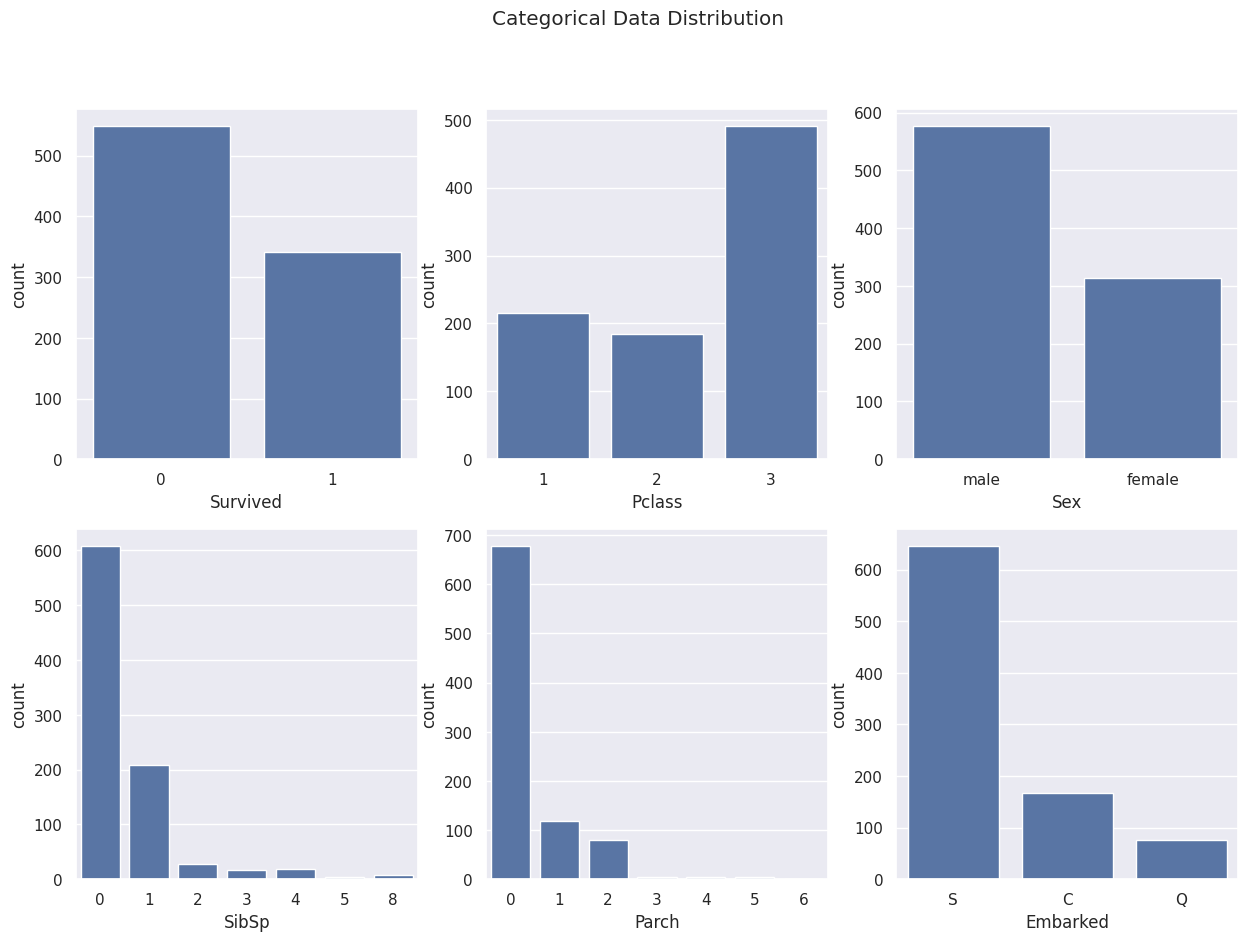

In [13]:
columns = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col, ax in zip(columns, axes.flatten()):
    sns.countplot(x=col, data=df, ax=ax)

plt.suptitle('Categorical Data Distribution')
plt.show();

Regarding categorical data, the distribution allows us to identify the highest and lowest scores within each category, as observed in the visualization. However, it is important to note that this distribution alone is insufficient. To gain more useful insights, we need to analyze how the passenger data is distributed by considering their survival status. Comparing the data distribution between survived and non-survived passengers enables us to uncover additional valuable insights and patterns that can inform our modeling and decision-making processes.

**Features by Target**

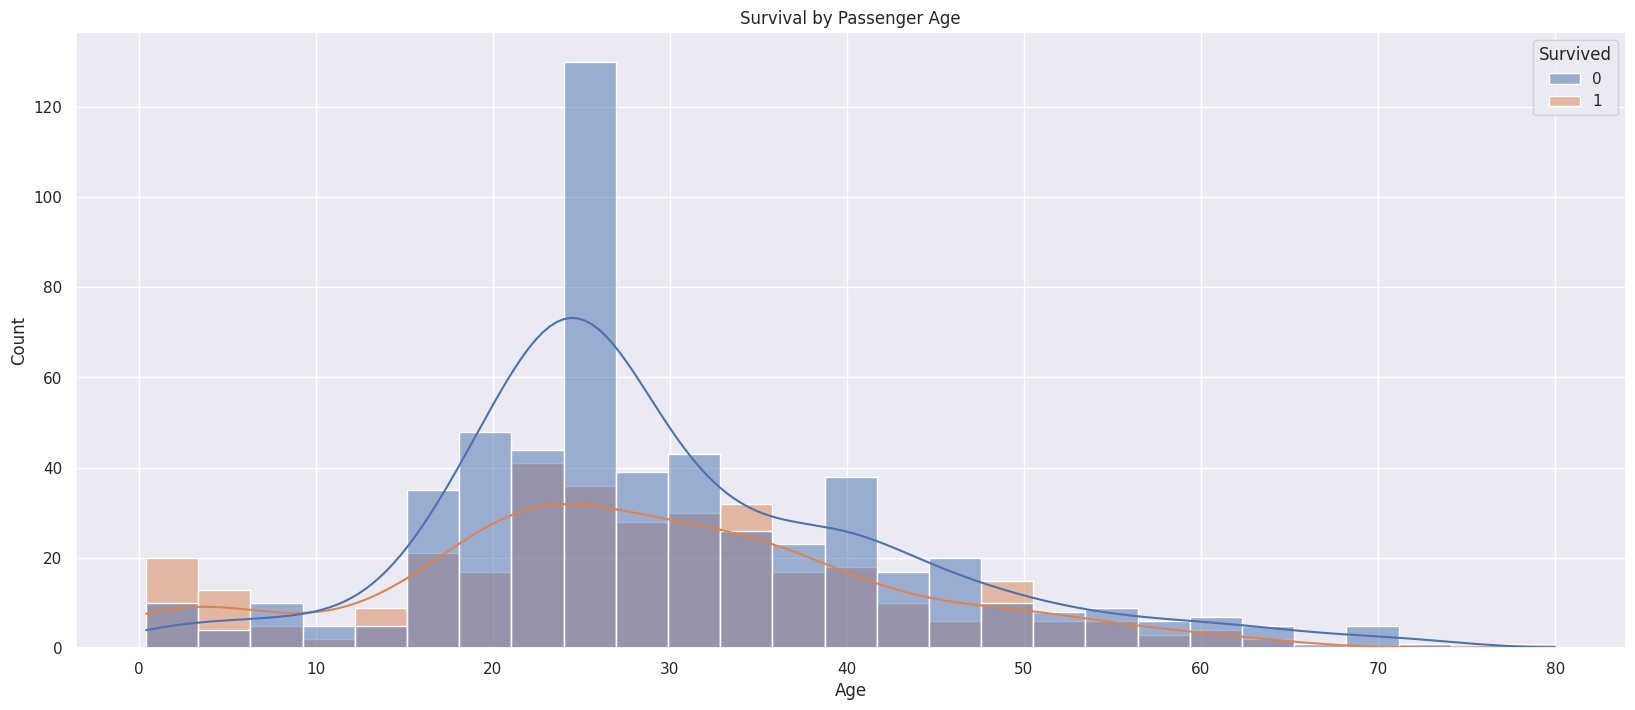

In [16]:
plt.figure(figsize=(20, 8))
sns.histplot(data=df, x='Age', hue='Survived', kde=True)
plt.title('Survival by Passenger Age');

Based on the visualization, it appears that young passengers in the baby or kid age range have a higher likelihood of survival compared to passengers in other age ranges. We can further group these age values into specified ranges to observe the survival probability within each age group. This approach can facilitate classification and enhance interpretability, as we group ages based on common knowledge.

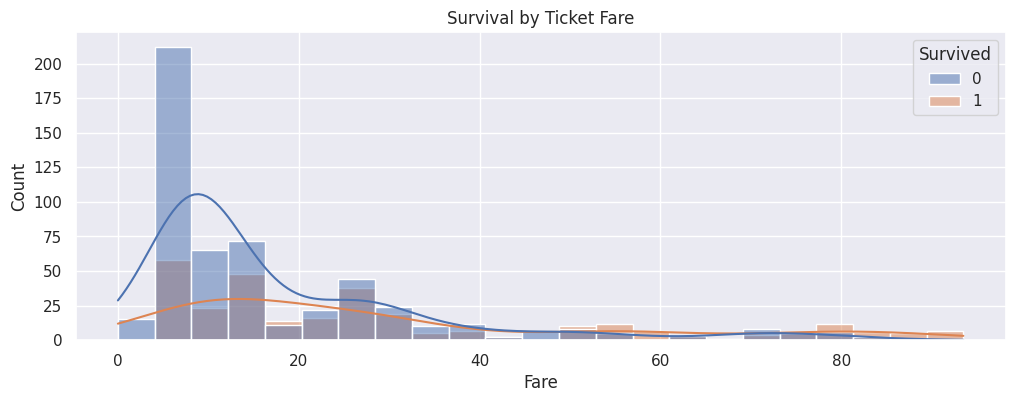

In [17]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df[df['Fare'] <= 100], x='Fare', hue='Survived', kde=True)
plt.title('Survival by Ticket Fare');

There is a wide range of fares observed, with a majority of lower fare values. It seems that higher fare values correlate with a higher probability of survival. Within the specific fare range of 0-100, passengers with the cheapest tickets (Fare < 20) tend to have a lower chance of survival, while those with more expensive tickets (Fare > 50) exhibit a higher probability of survival. However, for passengers with medium-fare tickets, it is difficult to draw definitive conclusions based on fare alone.

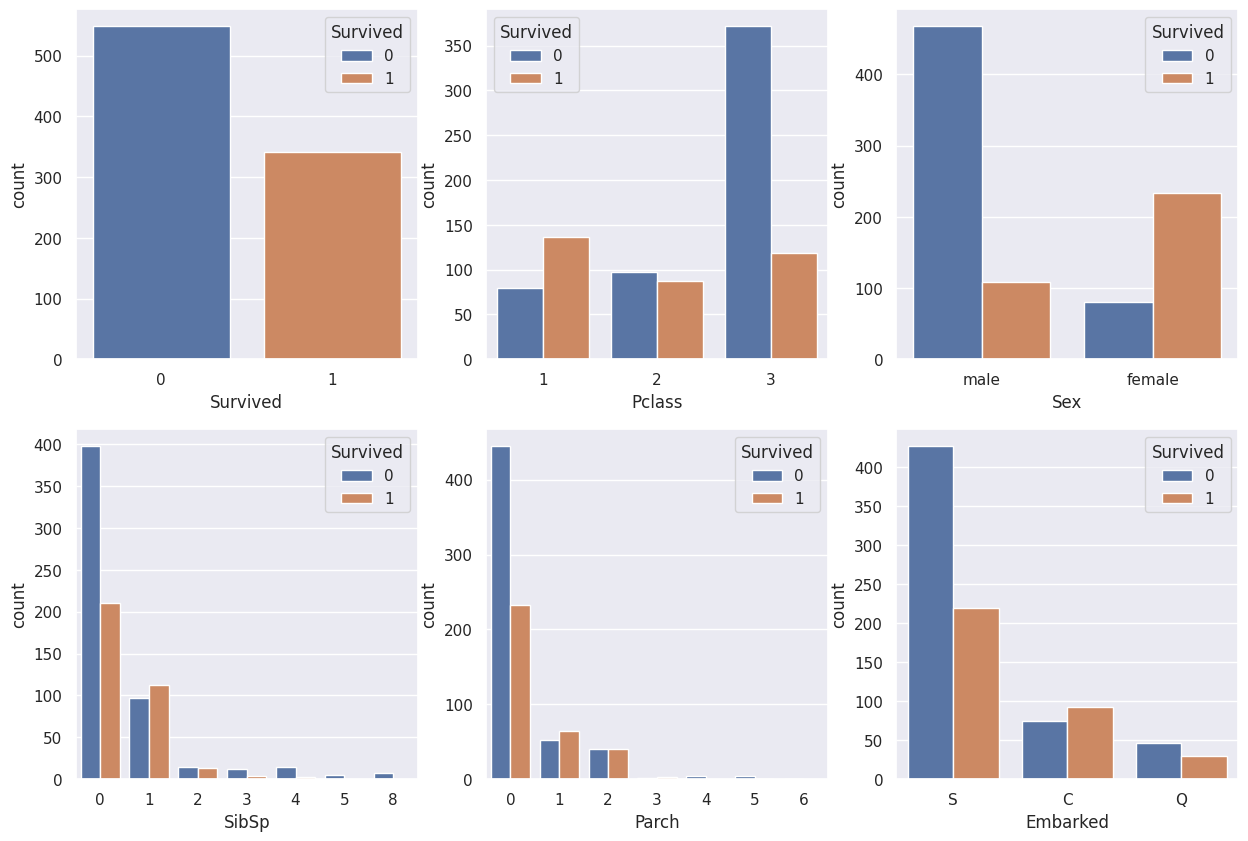

In [18]:
columns = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col, ax in zip(columns, axes.flatten()):
    sns.countplot(x=col, data=df, hue="Survived", ax=ax)

the analysis reveals that a significant number of unsurvived passengers (500+ people) belonged to Class 3, were male, traveled alone without siblings/spouses or parents/children, or embarked from Southampton (S port). Passengers falling into any of these categories generally have a lower chance of survival. On the other hand, passengers in Class 1, females, or those traveling with a small number of siblings/spouses/parents/children are more likely to survive.

**Correlation Analysis**

Analyzing correlations can shed light on the connections between different features. or numerical features, a Fcorrelation matrix is often employed. This matrix shows the correlation coefficient between features, revealing how strongly and in which direction two numbers are related. If the coefficient is near 1, they rise together (positive correlation). If it's closer to 0, there's no clear link (weak correlation). Around -1 indicates an inverse relationship – as one goes up, the other goes down.

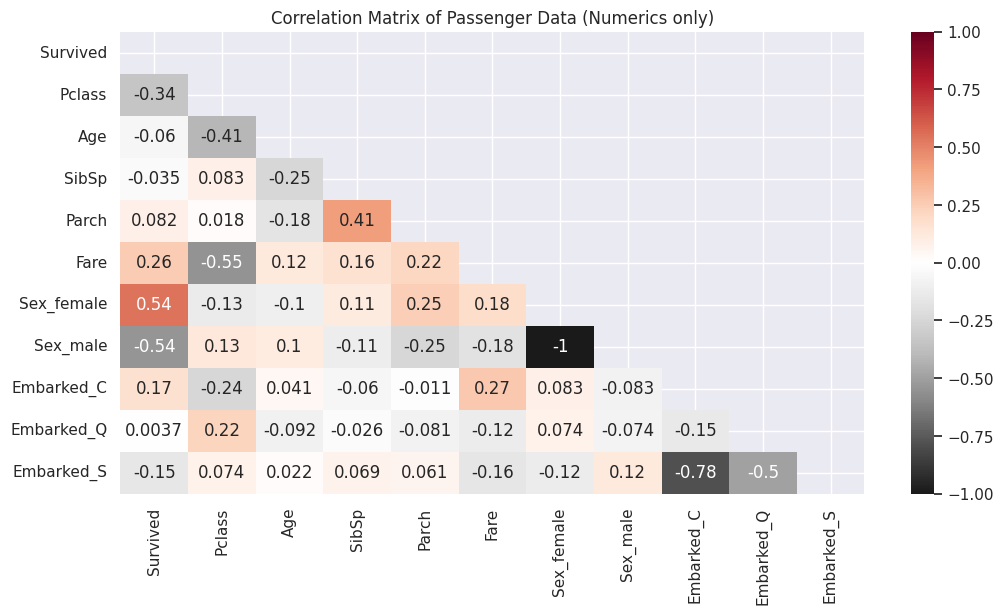

In [28]:
def plot_correlation_matrix(data, columns, figsize=(8,4)):
    corr = data[columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap='RdGy_r', mask=mask, vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Passenger Data (Numerics only)')
    plt.yticks(rotation=0)
    plt.show()
drop_cols = ['PassengerId', 'Name', 'Ticket']

# encode the categorical features then show correlaion matrix for all features (now all numerics)
df2 = pd.get_dummies(df.drop(columns=drop_cols), columns=['Sex', 'Embarked'])
plot_correlation_matrix(df2, df2.columns, figsize=(12,6))

From the visual representation above, we can glean several insights based on the correlations among data features. Let's break them down:

- Passenger Safety Levels: Features like Pclass, Sex, and Fare exhibit higher correlations compared to others. This suggests that they might be stronger predictors of passenger safety. Specifically, females, passengers with higher Fare tickets, and those with lower Pclass codes (indicating a higher social class) tend to have a better chance of survival. Interestingly, passengers who embarked from Cherbourg, France (C port) have a higher likelihood of survival, whereas those from Southampton, England (S port) are more likely not to survive. However, the correlation between Queenstown, Ireland (Q port) and passenger safety is less clear.

- C Port and Survival: The higher survival rate among passengers from the C port might be attributed to the fact that many affluent or socially higher-status individuals departed from there. The data does show a significant correlation between C embarked, Pclass, and Fare, which supports this relationship. The visualization suggests that passengers from port C often belong to lower Pclass codes (higher social classes) and purchase higher-fare tickets, potentially contributing to their improved safety. It's essential to note that this is a factual observation, not a statement of causality.

- Fare and Pclass Relationship: A notable and intriguing observation is the inverse correlation between Fare and Pclass. In other words, passengers with lower Pclass codes tend to have higher Fare tickets, indicating that higher social classes pay more for their tickets.

- Age and Passenger Safety: The correlation between age and passenger safety appears to be weak, which might impact predictions related to safety.

- SibSp and Parch: As seen in the distribution analysis stage, there is a correlation between SibSp (sibling/spouse count) and Parch (parent/child count), highlighting their interconnectedness.


# ***Feature Engineering***

we've identified some tweaks that could potentially enhance our model's accuracy. These adjustments involve categorizing numeric features like Age and Fare, where we group values into different ranges. This grouping transforms continuous numbers into categorical or ordinal values, helping the model grasp the underlying data patterns better. Our next move is to extract new features based on existing ones by pulling out common values. For instance, we can combine features such as SibSp and Parch into a single feature called Family.

In [31]:
# new dataframe for results of feature engineering
df_fe = df.copy()

To ensure reliability and accuracy, we will create age groups based on the original age data before performing any imputation. This approach avoids potential issues that may arise from using artificially generated data during the imputation process.

***Categorizing Age***

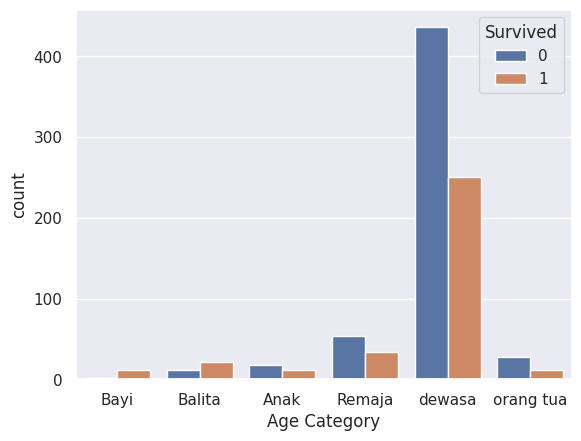

In [40]:
# group age based on bins division
bins = [-np.Inf, 1, 6, 14, 19, 55, np.Inf]
labels = ["Bayi","Balita","Anak","Remaja","dewasa","orang tua"]
df_fe["Age Category"] = pd.cut(x=df_fe["Age"], bins=bins, labels=labels, include_lowest=True)
sns.countplot(x="Age Category", data=df_fe, hue="Survived");

***Categorizing Fare***

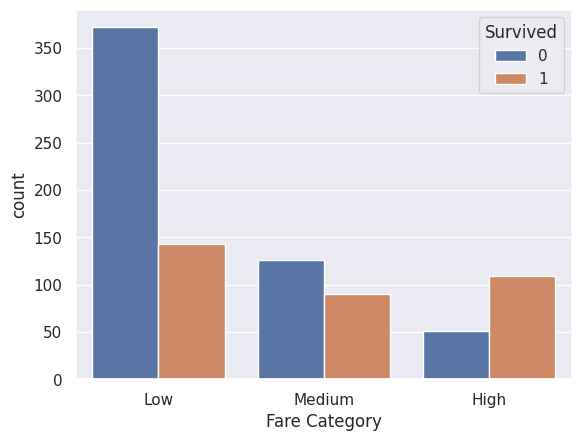

In [41]:
bins = [-np.Inf, 20, 50, np.Inf]
labels = ["Low","Medium","High"]
df_fe["Fare Category"] = pd.cut(x=df_fe["Fare"], bins=bins, labels=labels, include_lowest=True)
sns.countplot(x="Fare Category", data=df_fe, hue="Survived");

***Categorizing Family***

Here we're going to combine two features by addition resulting new feature Family, the total number of family sailed together with each passenger.

In [42]:
def count_family(data):
    return data["SibSp"] + data["Parch"] + 1

df_fe["Family"] = df_fe.apply(count_family, axis=1)

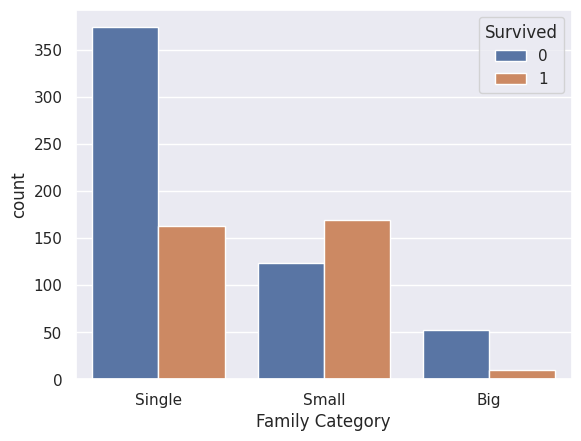

In [55]:
# group family based on bins division
bins = [-np.Inf, 1, 4, np.Inf]
labels = ["Single","Small","Big"]
df_fe["Family Category"] = pd.cut(x=df_fe["Family"], bins=bins, labels=labels)
sns.countplot(x="Family Category", data=df_fe, hue="Survived");

***Conclusion***

- Purpose and Scope: This report delved into the Titanic passenger dataset, focusing on exploratory data analysis (EDA) and feature engineering. Our aim was to improve the accuracy of our machine learning model's predictions for passenger survival.

- Key Findings: Our analysis uncovered insights into data characteristics, feature distributions, correlations, and their impact on survival. We identified opportunities to categorize continuous features like Age and Fare, leading to enhanced predictive capabilities.